In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader
from surprise import Dataset
from surprise import SVD

# Loading the data into movies and ratings dataframes

In [5]:
titles = pd.read_csv("data_transformed.csv")
ratings = pd.read_csv("ratings.csv")

# EDA

In [4]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11024289 entries, 0 to 11024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   rating     float64
 2   timestamp  int64  
 3   movieId    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 336.4+ MB
None


In [5]:
print(ratings.isnull().sum())

userId       0
rating       0
timestamp    0
movieId      0
dtype: int64


In [7]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22998 entries, 0 to 22997
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type           22998 non-null  object 
 1   title          22998 non-null  object 
 2   director       14739 non-null  object 
 3   cast           17677 non-null  object 
 4   country        11499 non-null  object 
 5   date_added     13444 non-null  object 
 6   release_year   22998 non-null  int64  
 7   rating         22998 non-null  object 
 8   listed_in      22998 non-null  object 
 9   description    22994 non-null  object 
 10  id             22998 non-null  object 
 11  duration_int   22516 non-null  float64
 12  duration_type  22516 non-null  object 
 13  score          22998 non-null  float64
dtypes: float64(2), int64(1), object(11)
memory usage: 2.5+ MB


In [8]:
titles.isnull().sum()

type                 0
title                0
director          8259
cast              5321
country          11499
date_added        9554
release_year         0
rating               0
listed_in            0
description          4
id                   0
duration_int       482
duration_type      482
score                0
dtype: int64

In [9]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 115077 unique users
The ratings dataset has 22998 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


<AxesSubplot: ylabel='Count'>

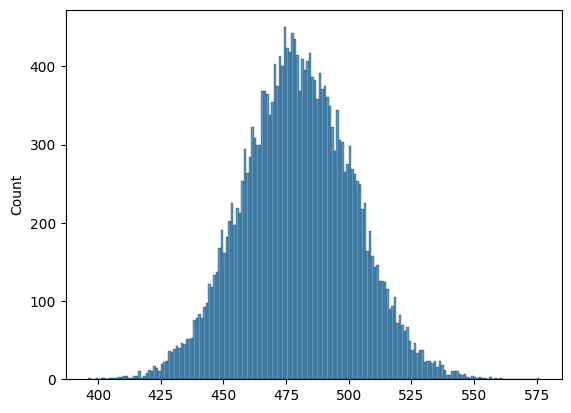

In [11]:
movie_ratings_count = ratings.groupby('movieId').size() #Counting the amount of ratings given to each movie
sns.histplot(movie_ratings_count, binwidth=1) #Visualizing the distribution

In [6]:
#We get check for duplicates, a given user rating the same movie twice.
duplicates = ratings.duplicated(subset=['userId', 'movieId'], keep=False)
print(ratings[duplicates].sort_values(['userId', 'movieId']))

         userId  rating   timestamp movieId
423          11     3.0  1231677016   ds275
429          11     2.0  1231677440   ds275
504          11     4.0  1231676547  ns3022
582          11     3.5  1231676662  ns3022
790          12     1.0   943910471  ns3580
...         ...     ...         ...     ...
9523469  270887     5.0  1487515358  ns8777
9521045  270887     5.0  1463582023  ns8787
9522011  270887     5.0  1463529592  ns8787
9524104  270896     4.0  1257034390  as7006
9524242  270896     4.0  1257031889  as7006

[254268 rows x 4 columns]


In [7]:
#We can see the dataframe has duplicates for same user same movie, we decide to take the last rating the user gave through taking the largest timestamp value.
ratings = ratings.sort_values('timestamp').drop_duplicates(subset=['userId', 'movieId'], keep='last')

#Now we check there are no duplicates left:
duplicates = ratings.duplicated(subset=['userId', 'movieId'], keep=False)
print(ratings[duplicates].sort_values(['userId', 'movieId']))

Empty DataFrame
Columns: [userId, rating, timestamp, movieId]
Index: []


# Data preprocessing for the model

In [8]:
ratings.drop(['timestamp'], axis=1, inplace=True) # We drop timestamp as it will not be of use in the model

In [34]:
# We load the datasets with these suprise library functions in order to feed the model
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Building the model

In [35]:
# Instanciate the SVD algorithm
algo = SVD(n_factors=10, random_state=42)

trainset = data.build_full_trainset()

# Fit the algorithm to the data
algo.fit(trainset)

# Get the item factors (the features for each movie)
item_features = algo.qi

#### Now we create a dataframe to be able to map each inner_id the model uses to the title of the movie the API will work with

In [56]:
# Create a column storing the inner_id of of each movie in our ratings dataframe
ratings['movieModelId'] = ratings['movieId'].apply(trainset.to_inner_iid)

In [57]:
# Create the title_ids df containing each pair of movieId and innerId, without duplicate entries
title_ids = ratings[['movieId', 'movieModelId']].drop_duplicates()

In [58]:
# Add the title column as well, getting each title from the titles df where the movieIds match
title_ids['title'] = title_ids['movieId'].apply(lambda x: titles[titles['id'] == x]['title'].values[0])

In [60]:
# Make the innerId the index to save space
title_ids.set_index('movieModelId', inplace=True)

In [24]:
# Export the features of the model and the movie ids to use with the API
np.savetxt("item_features.csv", item_features, delimiter=",")
title_ids.to_csv('title_ids.csv')